In [1]:
%matplotlib inline

import sys
sys.path.insert(0, "../fl_sim/")

In [2]:
import os
import random
import glob
import json
import torch
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# plt.rcParams["figure.figsize"] = (5,3)
plt.rcParams["figure.figsize"] = (10,6)

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from opts import get_args
from argparse import Namespace

from models import *
from data_funcs import *

# Utility functions
from utils.utils import top1_accuracy, \
    create_model_dir, init_metrics_meter, extend_metrics_dict, metric_to_dict
from utils.tasks import get_task_elements, get_agg, get_sampling, get_optimizer_init
from utils.logger import Logger

# Main Modules
from worker_gan import *
from server import TorchServer
from simulator import ParallelTrainer

# Hyperparameters

In [3]:
args_dict = {
    "task": "fedgan-linear-mixture1",
    "agg": "mean",
    "sampling": "fixed",
    "simulated_workers": 8,

    "seed": 123,
    "log_interval": 1,
    "identifier": "test",

    "comm_rounds": 60,
    "local_epochs": 2,
    "global_opt": "sgd",
    "local_opt": "sgd",
    "global_lr": 1.0,
    "local_lr": 0.1,
    "lr_sched": "exp",
    "batch_size": 10,

    "D_iters": 3,
    "ssl_reg": 0.5,

    "gpu": "0",
    "num_workers": 0,
    "loglevel": "INFO",
    "deterministic": True,
}

args = get_args(None, namespace=Namespace(**args_dict))

# Setup

In [4]:
# Logger
Logger.setup_logging("INFO", logfile="")
Logger()

Logger.get().disabled = True

# CUDA support
if torch.cuda.device_count():
    cuda_support = True
else:
    Logger.get().warning('CUDA unsupported!!')
    cuda_support = False

# Seed
if cuda_support:
    torch.cuda.manual_seed(args.seed)
    torch.cuda.manual_seed_all(args.seed)
random.seed(args.seed)
np.random.seed(args.seed)
os.environ['PYTHONHASHSEED'] = str(args.seed)
torch.manual_seed(args.seed)

# Loader kwargs
loader_kwargs = {}
if not args.device == 'cpu':
    loader_kwargs["num_workers"] = args.num_workers
    loader_kwargs["persistent_workers"] = args.num_workers > 0
train_loader_kwargs = {'batch_size': args.batch_size, 'shuffle': True, 'drop_last': True, **loader_kwargs}

## Task init

In [5]:
# Task inits
init_model, loss_func, is_rnn, test_batch_size, train_datasets, test_dataset = \
    get_task_elements(args.task, args.test_batch_size, args.data_path)

### DataLoaders, Models and Optimizers

In [6]:
test_loader = DataLoader(test_dataset, test_batch_size, shuffle=False, **loader_kwargs)
train_loader_s = [DataLoader(dataset, args.batch_size, shuffle=True, **loader_kwargs) for
                  dataset in train_datasets]

def count_params(module):
    return sum(p.numel() for p in module.parameters())

global_model = init_model().to(args.device)
Logger.get().info(f"Global model has {count_params(global_model)} parameters.")
local_model_s = [init_model().to(args.device) for _ in range(args.simulated_workers)]

local_opt_init = get_optimizer_init(args.local_opt, args.local_lr)
global_opt_init = get_optimizer_init(args.global_opt, args.global_lr)
server_opt = global_opt_init(global_model.parameters())

### Aggregator, Sampler, Metrics

In [7]:
agg = get_agg(args.aggregation)
client_sampler = get_sampling(args.sampling, args.comm_rounds, args.simulated_workers,
                              len(train_loader_s), args.seed)
if 'fedgan' in args.task:
    metrics = {k: (lambda _: 0.0) for k in TorchWorkerFedGAN.METRICS}
elif 'gan' in args.task:
    metrics = {k: (lambda _: 0.0) for k in TorchWorkerGAN.METRICS}
else:
    metrics = {'top_1_acc': top1_accuracy}
Logger.get().debug(f"metrics: {list(metrics.keys())}")

### Server, Trainer, and Workers

In [8]:
server = TorchServer(
    global_model=global_model,
    optimizer=server_opt
)
trainer = ParallelTrainer(
    server=server,
    aggregator=agg,
    client_sampler=client_sampler,
    datasets=train_datasets,
    data_loader_kwargs=train_loader_kwargs,
    log_interval=args.log_interval,
    metrics=metrics,
    device=args.device,
    lr_sched=args.lr_sched,
    aggregate_optim=args.aggregate_optim,
)

for worker_id, w_model in enumerate(local_model_s):
    worker = initialize_worker(
        worker_id=worker_id,
        model=w_model,
        optimizer_init=local_opt_init,
        device=args.device,
        server=server,
        log_interval=args.log_interval,
        fedgan=True,
        linear=True,
        # private_modules=['G.linear.weight' if 'mixture3' in args.task else 'G.linear.bias'],
    )
    trainer.add_worker(worker)

# Visualize Data

In [9]:
trainer.set_data_loaders(1)

In [10]:
dicts = []
for worker in trainer.workers:
    for data, target in worker.data_loader:
        for point, worker_id in zip(data.tolist(), target.tolist()):
            x, y = point
            dicts.append({'worker_id': worker_id, 'x': x, 'y': y})
df = pd.DataFrame(dicts)
df

,worker_id,x,y
0,0,1.290427,-1.643110
1,0,1.490913,-1.465011
2,0,1.253870,-1.752493
3,0,1.487410,-1.471761
4,0,1.783755,-1.193979
...,...,...,...
395,7,-1.246889,1.740104
396,7,-1.810430,1.182487
397,7,-1.471462,1.516556
398,7,-1.685638,1.309527


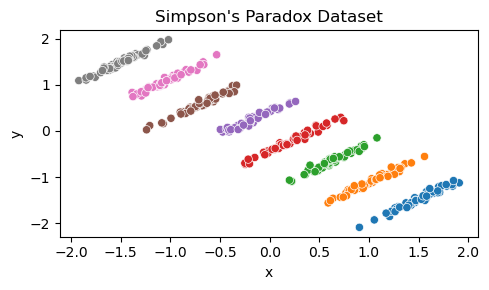

In [11]:

fig = plt.figure(figsize=(5,3))
sns.scatterplot(data=df, x='x', y='y', hue='worker_id', palette='tab10', legend=False)
# plt.legend(loc=1, prop={'size': 6})
plt.title("Simpson's Paradox Dataset")
plt.tight_layout()
plt.savefig("simpson_paradox_padpaf_real.pdf")
plt.show()

# sns.scatterplot(data=df, x='x', y='y', hue='worker_id', palette='tab10')

# Train

In [12]:
full_metrics = init_metrics_meter(metrics)
model_dir = create_model_dir(args)

In [13]:
# if os.path.exists(os.path.join(
#         model_dir, 'full_metrics.json')):
#     Logger.get().info(f"{model_dir} already exists.")
#     Logger.get().info("Skipping this setup.")
# else:

# create model directory
os.makedirs(model_dir, exist_ok=True)

for comm_round in range(1, args.comm_rounds + 1):
    Logger.get().info(f"Communication round {comm_round}/{args.comm_rounds}")
    train_metric = trainer.train(comm_round, local_epochs=args.local_epochs)
    extend_metrics_dict(
        full_metrics, metric_to_dict(train_metric, metrics, comm_round, 'train'))
#  store the run
with open(os.path.join(
        model_dir, 'full_metrics.json'), 'w') as f:
    json.dump(full_metrics, f, indent=4)

## Visualize

In [14]:
from matplotlib import animation
from IPython.display import HTML

frame_idx_map = {
    0: "real",
    1: "fix_c_fix_s",
    2: "fix_c_vary_s",
    3: "vary_c_fix_s",
    4: "vary_c_vary_s"
}

plt.ioff()
fig, ax = plt.subplots()

def animate(progress_idx):
    ax.cla()
    dicts = []
    for worker in trainer.workers:
        for frame_idx, frame in enumerate(worker.progress_frames[progress_idx]):
            for x, y in frame.tolist():
                dicts.append({'worker_id': worker.worker_id,
                              'type': frame_idx_map[frame_idx],
                              'x': x, 'y': y})
    df = pd.DataFrame(dicts)
    sns.scatterplot(x='x', y='y', hue='worker_id', style='type', palette='tab10', data=df, ax=ax, animated=True, legend=False)
    ax.set_xlim(-3,3)
    ax.set_ylim(-3,3)

ani = animation.FuncAnimation(fig, animate, frames=len(trainer.workers[0].progress_frames), interval=100)
# ani.save("simpson_paradox_fedgan.mp4")
HTML(ani.to_html5_video())

[2023-02-18 01:27:04] (36595) {animation.py:1050}INFO - Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
[2023-02-18 01:27:04] (36595) {animation.py:328}INFO - MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 1000x600 -pix_fmt rgba -r 10.0 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y /var/folders/zc/016yy9_n7sl3z1t5mzgpg2d80000gn/T/tmp0ulr2b_g/temp.m4v


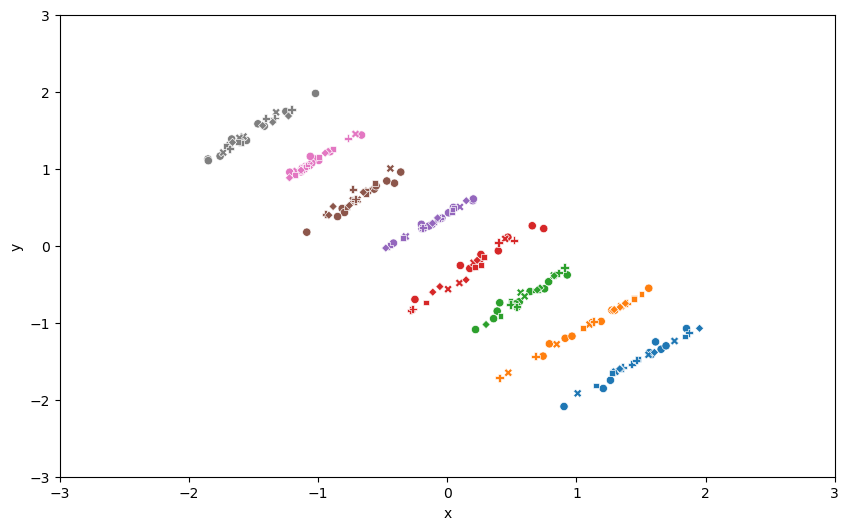

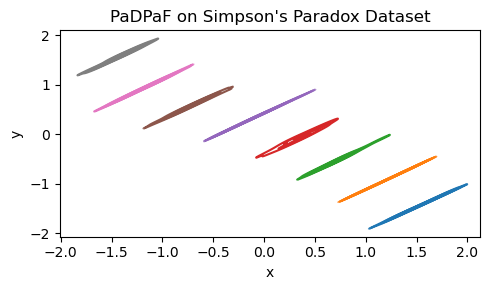

In [15]:
progress_idx = -1
dicts = []
for worker in trainer.workers:
    # for x, y in worker.progress_frames[progress_idx][0].tolist():
    #     dicts.append({'worker_id': worker.worker_id, 'type': 'real', 'x': x, 'y': y})
    # for frame in worker.progress_frames[progress_idx][1:]:
    #     for x, y in frame.tolist():
    #         dicts.append({'worker_id': worker.worker_id, 'type': 'fake', 'x': x, 'y': y})
    N = 50
    zc = torch.randn(N, worker.model.num_latents)
    zs = worker.model.style_map(torch.rand(N, worker.model.num_latents))
    points = worker.model.G(zc, cond=zs)
    for x, y in points.tolist():
        dicts.append({'worker_id': worker.worker_id, 'type': 'fake', 'x': x, 'y': y})
df = pd.DataFrame(dicts)
fig = plt.figure(figsize=(5,3))
sns.kdeplot(x='x', y='y', hue='worker_id', palette='tab10', data=df, legend=False)

plt.title("PaDPaF on Simpson's Paradox Dataset")
# plt.legend(loc=1, prop={'size': 6})
plt.tight_layout()
plt.savefig("simpson_paradox_padpaf_fake.pdf")
plt.show()

In [16]:
for worker in trainer.workers:
    print(f"Worker {worker.worker_id} ->\n  weight = {worker.model.G.linear.weight},\n  bias = {worker.model.G.linear.bias}")

Worker 0 ->
  weight = Parameter containing:
tensor([[-0.1504],
        [-0.1430]], requires_grad=True),
  bias = Parameter containing:
tensor([-0.1477,  0.2126], requires_grad=True)
Worker 1 ->
  weight = Parameter containing:
tensor([[-0.1500],
        [-0.1430]], requires_grad=True),
  bias = Parameter containing:
tensor([-0.1337,  0.2145], requires_grad=True)
Worker 2 ->
  weight = Parameter containing:
tensor([[-0.1495],
        [-0.1439]], requires_grad=True),
  bias = Parameter containing:
tensor([-0.1506,  0.2146], requires_grad=True)
Worker 3 ->
  weight = Parameter containing:
tensor([[-0.1515],
        [-0.1429]], requires_grad=True),
  bias = Parameter containing:
tensor([-0.1479,  0.2119], requires_grad=True)
Worker 4 ->
  weight = Parameter containing:
tensor([[-0.1510],
        [-0.1433]], requires_grad=True),
  bias = Parameter containing:
tensor([-0.1478,  0.2161], requires_grad=True)
Worker 5 ->
  weight = Parameter containing:
tensor([[-0.1528],
        [-0.1422]], r

## Can this model's discriminator learn how to detect worker id?

In [17]:
classifier_loss = nn.CrossEntropyLoss().to(trainer.device)
alldata_loader = DataLoader(test_dataset, args.batch_size, shuffle=True, **loader_kwargs)

def simple_train(classifier, classifier_optim, D=None, one_class=None):
    for e in range(20):
        loss_mean = 0.
        hits_mean = 0.
        for i, (data, target) in enumerate(alldata_loader):
            data, target = data.to(args.device), target.to(args.device)
            batch_size = data.shape[0]
            classifier_optim.zero_grad()
            if D is not None:
                with torch.no_grad():
                    _, data = D(data, return_h=True)
            if one_class is not None:
                target = (target == one_class).long()
            output = classifier(data)
            loss = classifier_loss(output, target)
            hits = (output.max(dim=1).indices == target).sum()
            loss.backward()
            classifier_optim.step()
            loss_mean += loss.item() / len(alldata_loader)
            hits_mean += hits.item() / len(alldata_loader)
        print(f"E{e+1:02d}: loss = {loss_mean}, acc = {hits_mean / batch_size:.4f}")

### Linear classifier on data

In [18]:
classifier = nn.Linear(2, len(trainer.workers))
classifier_optim = torch.optim.Adam(classifier.parameters(), lr=0.1)

simple_train(classifier, classifier_optim, D=None)

E01: loss = 1.5685158729553221, acc = 0.3700
E02: loss = 1.1449386343359946, acc = 0.6325
E03: loss = 1.0219743341207503, acc = 0.6750
E04: loss = 0.9315303176641461, acc = 0.7175
E05: loss = 0.8664790272712705, acc = 0.8350
E06: loss = 0.8214775979518889, acc = 0.8225
E07: loss = 0.7666122809052469, acc = 0.9000
E08: loss = 0.7564020290970802, acc = 0.8425
E09: loss = 0.6978078655898572, acc = 0.9125
E10: loss = 0.6579360656440258, acc = 0.9850
E11: loss = 0.6540754660964013, acc = 0.9300
E12: loss = 0.615259413421154, acc = 0.9900
E13: loss = 0.594311761111021, acc = 0.9525
E14: loss = 0.5795885615050794, acc = 0.9650
E15: loss = 0.5463887184858321, acc = 0.9975
E16: loss = 0.5362419746816156, acc = 0.9700
E17: loss = 0.5185467883944511, acc = 0.9625
E18: loss = 0.5047550715506078, acc = 1.0000
E19: loss = 0.4856003329157829, acc = 0.9950
E20: loss = 0.47003752663731585, acc = 1.0000


### Linear classifier on hidden feature of contentD

In [19]:
D = global_model.contentD
classifier = nn.Linear(D.hidden_dim, len(trainer.workers))
classifier_optim = torch.optim.Adam(classifier.parameters(), lr=0.1)

simple_train(classifier, classifier_optim, D=D)

E01: loss = 1.4581325292587277, acc = 0.4100
E02: loss = 0.9706109136343, acc = 0.7000
E03: loss = 0.8157823786139489, acc = 0.7800
E04: loss = 0.7073244117200376, acc = 0.8275
E05: loss = 0.6406981319189072, acc = 0.8525
E06: loss = 0.5594842202961444, acc = 0.8850
E07: loss = 0.5044108971953392, acc = 0.9150
E08: loss = 0.4676243156194687, acc = 0.9200
E09: loss = 0.42855611331760884, acc = 0.9325
E10: loss = 0.39598658345639703, acc = 0.9350
E11: loss = 0.3689726147800683, acc = 0.9400
E12: loss = 0.34694988876581184, acc = 0.9850
E13: loss = 0.321242293715477, acc = 0.9725
E14: loss = 0.3020840935409069, acc = 0.9900
E15: loss = 0.2913841076195239, acc = 0.9575
E16: loss = 0.26545621193945407, acc = 0.9975
E17: loss = 0.2627275697886944, acc = 0.9900
E18: loss = 0.2485023319721222, acc = 0.9825
E19: loss = 0.2424753937870264, acc = 0.9800
E20: loss = 0.2294099466875196, acc = 0.9700


### Linear classifier on hidden feature of styleD of worker1

In [20]:
D = trainer.workers[0].model.styleD
classifier = nn.Linear(D.hidden_dim, len(trainer.workers))
classifier_optim = torch.optim.Adam(classifier.parameters(), lr=0.1)

simple_train(classifier, classifier_optim, D=D)

E01: loss = 1.882276314496994, acc = 0.2175
E02: loss = 1.5746597170829773, acc = 0.3275
E03: loss = 1.5045273095369338, acc = 0.3425
E04: loss = 1.4318849444389345, acc = 0.3675
E05: loss = 1.3899706810712815, acc = 0.3875
E06: loss = 1.3815629154443738, acc = 0.4025
E07: loss = 1.3500578001141548, acc = 0.4050
E08: loss = 1.3212505668401717, acc = 0.4425
E09: loss = 1.3145125985145572, acc = 0.4225
E10: loss = 1.2982537448406217, acc = 0.4125
E11: loss = 1.270314408838749, acc = 0.4450
E12: loss = 1.2786689490079879, acc = 0.4650
E13: loss = 1.2708501785993573, acc = 0.4225
E14: loss = 1.2501565858721733, acc = 0.4500
E15: loss = 1.2544426366686825, acc = 0.4425
E16: loss = 1.268752409517765, acc = 0.4500
E17: loss = 1.2181414380669595, acc = 0.4650
E18: loss = 1.208689537644386, acc = 0.5000
E19: loss = 1.220195668935776, acc = 0.5000
E20: loss = 1.2033807188272476, acc = 0.4750


### Linear classifier on hidden feature of styleD of worker[0] for detecting its own data only

In [21]:
D = trainer.workers[0].model.styleD
classifier = nn.Linear(D.hidden_dim, 2)
classifier_optim = torch.optim.Adam(classifier.parameters(), lr=0.1)

simple_train(classifier, classifier_optim, D=D, one_class=trainer.workers[0].worker_id)

E01: loss = 0.23239529875572765, acc = 0.9025
E02: loss = 0.17070801444351677, acc = 0.9175
E03: loss = 0.1610089527443051, acc = 0.9200
E04: loss = 0.16101407455280423, acc = 0.9175
E05: loss = 0.16226208824664357, acc = 0.9200
E06: loss = 0.15384717370616274, acc = 0.9200
E07: loss = 0.15409749445680057, acc = 0.9225
E08: loss = 0.1527736045653, acc = 0.9225
E09: loss = 0.14700141685170817, acc = 0.9225
E10: loss = 0.1549536394653842, acc = 0.9175
E11: loss = 0.14878358033020048, acc = 0.9175
E12: loss = 0.1450207427435089, acc = 0.9275
E13: loss = 0.14703888011863453, acc = 0.9275
E14: loss = 0.13832391441101208, acc = 0.9350
E15: loss = 0.1403633840032853, acc = 0.9275
E16: loss = 0.13796332267811523, acc = 0.9300
E17: loss = 0.13657906727166844, acc = 0.9300
E18: loss = 0.13440059289569034, acc = 0.9325
E19: loss = 0.13106345747946763, acc = 0.9350
E20: loss = 0.13317277850583195, acc = 0.9375


### Linear classifier on hidden feature of styleD of worker[0] for detecting worker[-1] data only

In [22]:
D = trainer.workers[0].model.styleD
classifier = nn.Linear(D.hidden_dim, 2)
classifier_optim = torch.optim.Adam(classifier.parameters(), lr=0.1)

simple_train(classifier, classifier_optim, D=D, one_class=trainer.workers[-1].worker_id)

E01: loss = 0.44612237624824047, acc = 0.8525
E02: loss = 0.28409267254173753, acc = 0.8750
E03: loss = 0.25589802321046584, acc = 0.8750
E04: loss = 0.24645504876971247, acc = 0.8825
E05: loss = 0.22710301242768766, acc = 0.8825
E06: loss = 0.21658984813839194, acc = 0.8950
E07: loss = 0.21160598266869785, acc = 0.9000
E08: loss = 0.19756971029564735, acc = 0.9150
E09: loss = 0.19405549052171409, acc = 0.9075
E10: loss = 0.18773807594552636, acc = 0.9150
E11: loss = 0.19430921450257302, acc = 0.9150
E12: loss = 0.18260738652897998, acc = 0.9125
E13: loss = 0.17058522095903755, acc = 0.9250
E14: loss = 0.16760197670664642, acc = 0.9425
E15: loss = 0.1739051856100559, acc = 0.9325
E16: loss = 0.158620633976534, acc = 0.9275
E17: loss = 0.16425175499171019, acc = 0.9275
E18: loss = 0.16167545532807706, acc = 0.9325
E19: loss = 0.15542549695819619, acc = 0.9325
E20: loss = 0.14840272893197834, acc = 0.9450


### Train a classifier on top of worker-specific classifiers (obviously should work better)

In [23]:
alldata_loader = DataLoader(test_dataset, args.batch_size, shuffle=True, **loader_kwargs)
agg_classifer = nn.Linear(len(trainer.workers), len(trainer.workers))
torch.nn.init.constant_(agg_classifer.weight.data, 1 / len(trainer.workers))
classifiers = [nn.Linear(global_model.styleD.hidden_dim, 1) for worker in trainer.workers]
optim = torch.optim.Adam([{'params': agg_classifer.parameters()}]
                          + [{"params": classifier.parameters()} for classifier in classifiers], lr=0.1)

for e in range(20):
    loss_mean = 0.
    hits_mean = 0.
    for i, (data, target) in enumerate(alldata_loader):
        data, target = data.to(args.device), target.to(args.device)
        batch_size = data.shape[0]
        optim.zero_grad()

        with torch.no_grad():
            hs = [worker.model.styleD(data, return_h=True)[1] for worker in trainer.workers]
        outputs = torch.stack([classifier(h) for classifier, h in zip(classifiers, hs)], dim=1)
        output = agg_classifer(outputs.squeeze(-1))

        loss = F.cross_entropy(output, target)
        hits = (output.max(dim=1).indices == target).sum()
        loss.backward()
        optim.step()

        loss_mean += loss.item() / len(alldata_loader)
        hits_mean += hits.item() / len(alldata_loader)
    print(f"E{e+1:02d}: loss = {loss_mean}, acc = {hits_mean / batch_size}")

routing_mse = loss_mean

E01: loss = 0.9933265350759032, acc = 0.5974999999999998
E02: loss = 0.30411477703601125, acc = 0.8824999999999997
E03: loss = 0.09804144478403036, acc = 0.9799999999999999
E04: loss = 0.04474538625217974, acc = 1.0
E05: loss = 0.028516491409391165, acc = 1.0
E06: loss = 0.016976294037885965, acc = 1.0
E07: loss = 0.012144375673960893, acc = 1.0
E08: loss = 0.010663672233931717, acc = 1.0
E09: loss = 0.010370262403739616, acc = 1.0
E10: loss = 0.006710226534050891, acc = 1.0
E11: loss = 0.004340395174222067, acc = 1.0
E12: loss = 0.0038818807253846906, acc = 1.0
E13: loss = 0.003094209835398942, acc = 1.0
E14: loss = 0.0030011486203875394, acc = 1.0
E15: loss = 0.0023578982436447404, acc = 1.0
E16: loss = 0.002047220256645234, acc = 1.0
E17: loss = 0.001865868261666037, acc = 1.0
E18: loss = 0.0016234128343057814, acc = 1.0
E19: loss = 0.0014974891179008413, acc = 1.0
E20: loss = 0.0013229064366896636, acc = 1.0
